In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("final_project").getOrCreate()

In [2]:
spark

# 1 load and explore data

In [3]:
#read data
df2004 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2004.csv",
                      header = True, inferSchema= True)
df2005 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2005.csv",
                      header = True, inferSchema= True)
df2006 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2006.csv",
                      header = True, inferSchema= True)
df2007 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2007.csv",
                      header = True, inferSchema= True)
df2008 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2008.csv",
                      header = True, inferSchema= True)
df2009 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2009.csv",
                      header = True, inferSchema= True)
df2010 = spark.read.csv("s3://jenova73/final/311_Service_Requests_from_2010_to_Present (1).csv",
                      header = True, inferSchema= True)

In [4]:
#chech the schema of data
df2010.printSchema()
df2004.printSchema()


root
 |-- Unique Key: integer (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- Incident Address: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Cross Street 1: string (nullable = true)
 |-- Cross Street 2: string (nullable = true)
 |-- Intersection Street 1: string (nullable = true)
 |-- Intersection Street 2: string (nullable = true)
 |-- Address Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Due Date: string (nullable = true)
 |-- Resolution Description: string (nullable = true)
 |-- Resolution Actio

In [5]:
# remove other columns and keep required
columns = ['Created Date','Closed Date','Agency','Agency Name',
          'Complaint Type','Descriptor','Location Type','Incident Zip',
          'City','Status','Community Board','Borough','Park Borough',
          'Latitude','Longitude']

In [7]:
# merge all data together
merged = df2004.union(df2005)
merged = merged.union(df2006)
merged = merged.union(df2007)
merged = merged.union(df2008)
merged = merged.union(df2009)

#since the difference of data of 2010, we need to do it seperately
merged = merged.select(*columns)
df2010=df2010.select(*columns)
data = merged.union(df2010)


In [8]:
data.printSchema()

root
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Park Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [9]:
data.count()

32953164

In [10]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf,rank,sum
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StringType, IntegerType, FloatType

In [11]:
# drop na data
data=data.dropna()

In [12]:
data.count()

21920178

# 2 EDA

In [44]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pyspark.sql import Window
import pandas

# check most frequent objects in specific columns
def bar_plot(data,column,n):
    plot = data.select([column]).\
       groupBy(column).\
       agg(F.count(column).alias('nums'))
    df = plot.toPandas()
    df=df.sort_values(by=['nums'],ascending=False)
    df=df[:n]
    print(df)
    plt.figure(figsize=(15,10))
    plt.xticks(rotation=45)
    plt.bar(df[column],df['nums'])


/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


              City     nums
57        BROOKLYN  7246100
90           BRONX  4697798
125       NEW YORK  4488321
144  STATEN ISLAND   903565
133        JAMAICA   377391


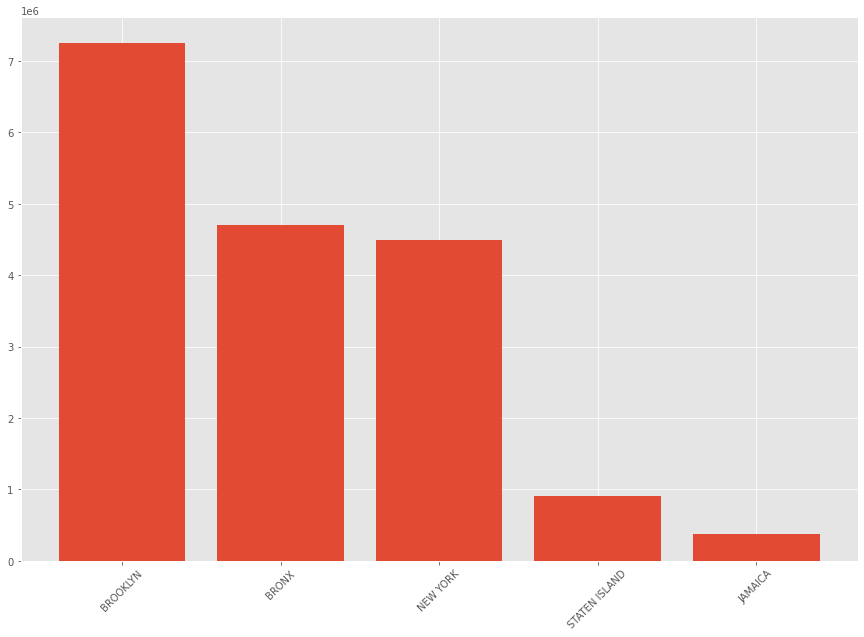

In [46]:
# 5 most frequent city
bar_plot(data,'City', 5)

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


          Complaint Type     nums
164              HEATING  2220489
44   Noise - Residential  1849472
78        HEAT/HOT WATER  1294683
146             PLUMBING  1290506
72      Blocked Driveway  1223661


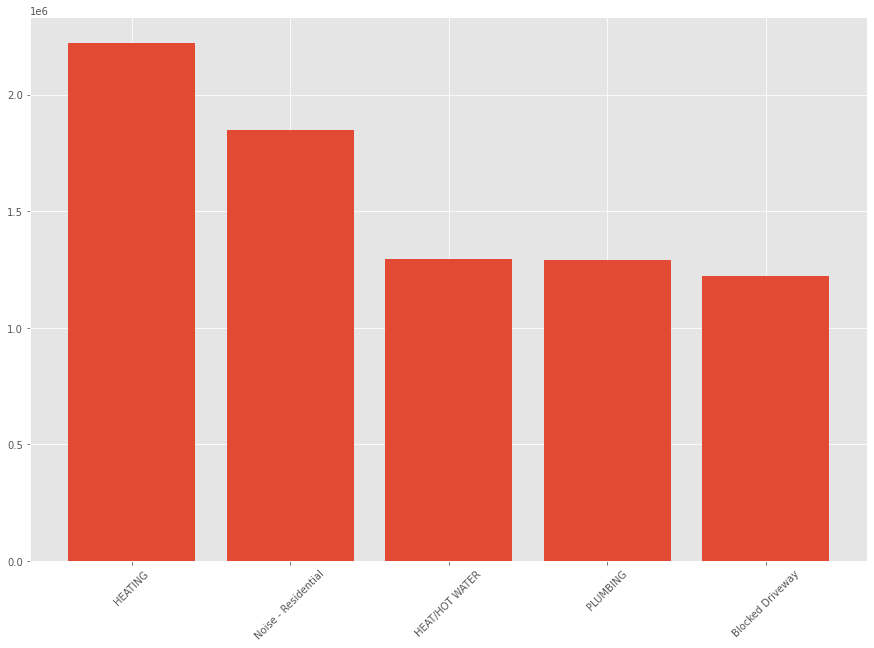

In [47]:
# 5 most frequent Complaint Type
bar_plot(data,'Complaint Type', 5)

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


                                            Agency Name     nums
463   Department of Housing Preservation and Develop...  9663527
1636                    New York City Police Department  6412682
447                        Department of Transportation  1373609
1799                 Department of Parks and Recreation   849771
1216            Department of Health and Mental Hygiene   592402


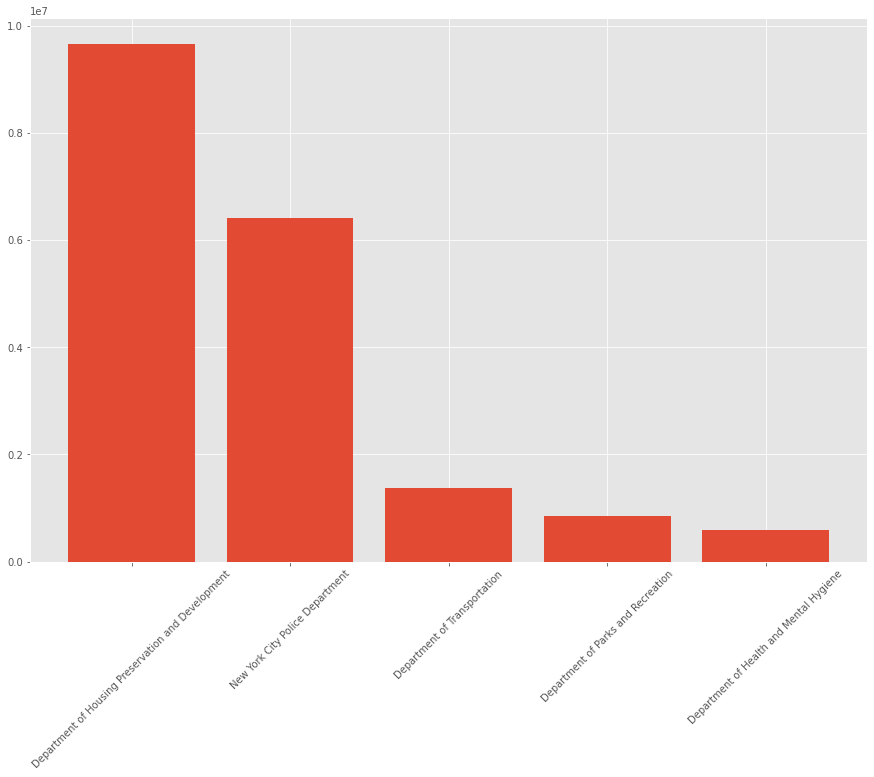

In [48]:
# 5 most frequent Agency
bar_plot(data,'Agency Name', 5)

# 3 Data Cleaning

In [49]:
# change data into appropriate data
from pyspark.sql.functions import to_date, to_timestamp, datediff,year, month
df1=data.withColumn("start_date", to_date('Created Date','MM/dd/yyyy HH:mm:ss'))
df1=df1.withColumn("end_date", to_date('Closed Date','MM/dd/yyyy HH:mm:ss'))
df1=df1.withColumn('Time',datediff('end_date','start_date'))
df1= df1.withColumn('Timebin',F.when(df1.Time<3, 0).otherwise(F.when(df1.Time<7,1).otherwise(2)))
df1=df1.withColumn('Year',year('start_date'))
df1=df1.withColumn('Month',month('start_date'))
df1=df1.drop('Created Date','Closed Date','start_date','end_date','Time')


In [50]:
df1 = df1.withColumn("Timebin",col("Timebin").cast(StringType()))
df1 = df1.withColumn("Year",col("Year").cast(StringType()))
df1 = df1.withColumn("Month",col("Month").cast(StringType()))


In [51]:
df1.printSchema()

root
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Park Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Timebin: string (nullable = false)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)



/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


    Year     nums
11  2004   733522
7   2005  1162979
10  2006  1096505
14  2007  1150875
13  2008  1166142
8   2009  1135102
16  2010  1306354
12  2011  1195828
1   2012  1203968
6   2013  1236465
5   2014  1447394
15  2015  1563722
0   2016  1684453
4   2017  1802083
9   2018  2004471
3   2019  1681892
2   2020   348423


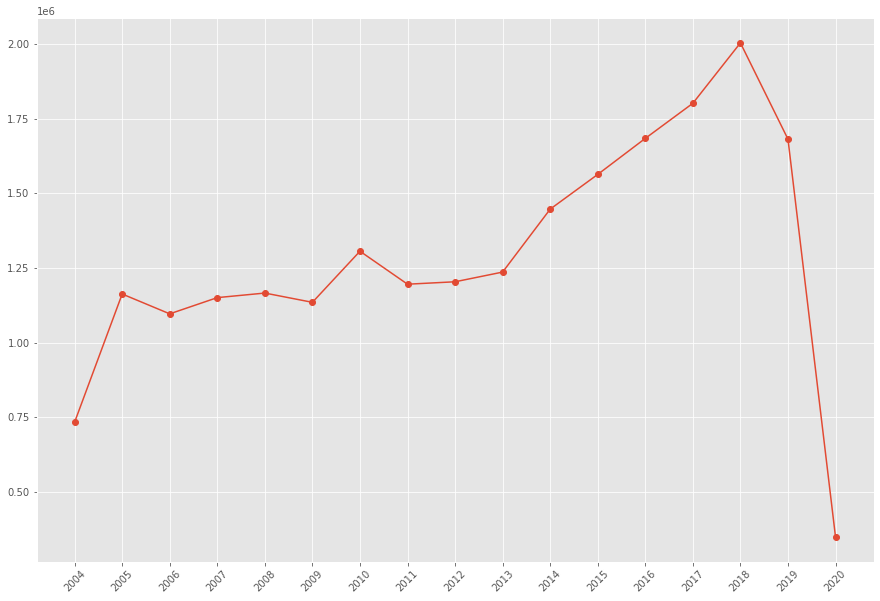

In [57]:
# number in each year
def line_plot(data,column):
    plot = data.select([column]).\
       groupBy(column).\
       agg(F.count(column).alias('nums'))
    df = plot.toPandas()
    df=df.sort_values(by=[column],ascending=True)
    print(df)
    plt.figure(figsize=(15,10))
    plt.xticks(rotation=45)
    plt.plot(df[column],df['nums'],'o-')


line_plot(df1,'Year')

In [60]:
# see the cross table between year and borough

df1.crosstab('Year', 'Borough').show()

+------------+------+--------+---------+------+-------------+-----------+
|Year_Borough| BRONX|BROOKLYN|MANHATTAN|QUEENS|STATEN ISLAND|Unspecified|
+------------+------+--------+---------+------+-------------+-----------+
|        2014|316296|  471700|   299207|302816|        57330|         45|
|        2020| 78397|  106794|    72417| 77389|        13426|          0|
|        2013|269877|  407296|   259191|251708|        48259|        134|
|        2018|389709|  664673|   358653|483266|       104952|       3218|
|        2007| 55674|  143679|   111748|129523|        31420|     678831|
|        2004| 46265|  105227|    75950| 87529|        22155|     396396|
|        2015|330351|  502642|   328661|338760|        63305|          3|
|        2011|215121|  359940|   211157|233815|        47725|     128070|
|        2008| 58092|  148087|   115257|138340|        32548|     673818|
|        2012|259704|  401149|   236844|257409|        48851|         11|
|        2019|331112|  550889|   31135

# 4 prepare data

In [55]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
import numpy as np

In [19]:
# latitude and longitude is not required in regression
df1=df1.drop('Longitude','Latitude')
df1=df1.dropna()

In [61]:
# split data into train and test as 3:1
(train, test) = (df1.randomSplit([0.75,0.25]))

### change string or integer into index

In [62]:
Agency_indexer = StringIndexer(inputCol = 'Agency',outputCol='Agency_index').setHandleInvalid("keep")
Agency_Name_indexer = StringIndexer(inputCol = 'Agency Name',outputCol='Agency_Name_index').setHandleInvalid("keep")
Complaint_Type_indexer = StringIndexer(inputCol = 'Complaint Type',outputCol='Complaint_Type_index').setHandleInvalid("keep")
Descriptor_indexer = StringIndexer(inputCol = 'Descriptor',outputCol='Descriptor_index').setHandleInvalid("keep")
Location_Type_indexer = StringIndexer(inputCol = 'Location Type',outputCol='Location_Type_index').setHandleInvalid("keep")
Incident_indexer = StringIndexer(inputCol = 'Incident Zip',outputCol='Incident_index').setHandleInvalid("keep")
City_indexer = StringIndexer(inputCol = 'City',outputCol='City_index').setHandleInvalid("keep")
Status_indexer = StringIndexer(inputCol = 'Status',outputCol='Status_index').setHandleInvalid("keep")
Community_Board_indexer = StringIndexer(inputCol = 'Community Board',outputCol='Community_Board_index')
Borough_indexer = StringIndexer(inputCol = 'Borough',outputCol='Borough_index').setHandleInvalid("keep")
Park_indexer= StringIndexer(inputCol = 'Park Borough',outputCol='Park_index').setHandleInvalid("keep")
Timebin_indexer = StringIndexer(inputCol = 'Timebin',outputCol='label').setHandleInvalid("keep")
Year_indexer = StringIndexer(inputCol = 'Year',outputCol='Year_index').setHandleInvalid("keep")
Month_indexer = StringIndexer(inputCol = 'Month',outputCol='Month_index').setHandleInvalid("keep")

In [63]:
# assemble all features and label
assembler = VectorAssembler(inputCols = ["Agency_index", 
                                         "Agency_Name_index",
                                         "Complaint_Type_index",
                                         "Descriptor_index",
                                         "Location_Type_index",
                                         "Incident_index",
                                         "Status_index",
                                         "Borough_index",
                                         "Community_Board_index",
                                         "Park_index",'City_index',
                                        'Year_index','Month_index'],
                            outputCol = 'features')

# 5 Logistics Regression

In [64]:
#use logistic regression
Logistic_regression_pipeline = Pipeline(stages=[Agency_indexer,
                                       Agency_Name_indexer,Complaint_Type_indexer,
                                     Descriptor_indexer,Location_Type_indexer,Incident_indexer,
                                     Status_indexer,Community_Board_indexer,Borough_indexer,
                                     Park_indexer,City_indexer,Timebin_indexer,Year_indexer,Month_indexer,
                                     assembler,
                                     LogisticRegression(featuresCol = 'features',labelCol = 'label')])

In [67]:
logistic_model = Logistic_regression_pipeline.fit(train)

In [68]:
logistic_model.save("s3://jenova73/final/model/logistic_model")

In [69]:
prediction = logistic_model.transform(test).cache()

In [70]:
# check the result
evaluator = MulticlassClassificationEvaluator() 
print('F1-Score ', evaluator.evaluate(prediction, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(prediction,
                                       {evaluator.metricName:                    'weightedPrecision'}))
print('Recall ', evaluator.evaluate(prediction, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(prediction, 
                                      {evaluator.metricName: 'accuracy'}))

F1-Score  0.5422110288637008
Precision  0.5164027559372757
Recall  0.5957108034241347
Accuracy  0.5957108034241347


# 6 Random Forest 

In [71]:
rf = RandomForestClassifier(featuresCol = 'features',labelCol = 'label',maxDepth=2,maxBins=2000)
paramGrid = ParamGridBuilder().addGrid(rf.maxBins, 
                                       [2000]).addGrid(rf.maxDepth, [8]).addGrid(rf.impurity, ["entropy", "gini"]).build()


In [72]:
rf_pipeline = Pipeline(stages=[Agency_indexer,
                                Agency_Name_indexer,Complaint_Type_indexer,
                                Descriptor_indexer,Location_Type_indexer,Incident_indexer,
                                     Status_indexer,Community_Board_indexer,Borough_indexer,
                                     Park_indexer,City_indexer,Timebin_indexer,Year_indexer,Month_indexer,
                                     assembler,rf])

In [74]:
rf_model = rf_pipeline.fit(train)

In [75]:
rf_model.save("s3://jenova73/final/model/random_forest_model")

In [77]:
rf_prediction = rf_model.transform(test).cache()

In [79]:
# check the result
evaluator = MulticlassClassificationEvaluator() 
print('F1-Score ', evaluator.evaluate(rf_prediction, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(rf_prediction,
                                       {evaluator.metricName:                    'weightedPrecision'}))
print('Recall ', evaluator.evaluate(rf_prediction, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(rf_prediction, 
                                      {evaluator.metricName: 'accuracy'}))

F1-Score  0.6592298897008793
Precision  0.6573170323369681
Recall  0.7096768192425648
Accuracy  0.7096768192425648


# 7 Confusion matrix

In [80]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [81]:
#build a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [82]:
ytrue = prediction.select('label')
ytrue = ytrue.toPandas()

ypred = prediction.select('prediction')
ypred = ypred.toPandas()


/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


In [83]:
cnf_matrix = confusion_matrix(ytrue, ypred,labels=range(3))

In [84]:
cnf_matrix

array([[2133648,  515630,     121],
       [ 855130, 1132504,     232],
       [ 496703,  348839,      38]])

Normalized confusion matrix
[[8.05332832e-01 1.94621497e-01 4.56707351e-05]
 [4.30174871e-01 5.69708421e-01 1.16708068e-04]
 [5.87411008e-01 4.12544053e-01 4.49395681e-05]]


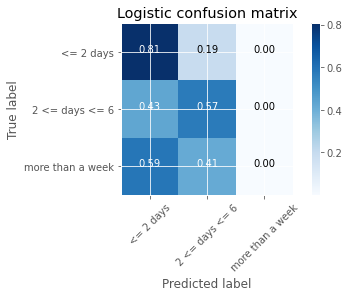

In [85]:
# change the name of labels
class_names = ['<= 2 days','2 <= days <= 6','more than a week',]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Logistic confusion matrix')
plt.show()

In [86]:
ytrue = rf_prediction.select('label')
ytrue = ytrue.toPandas()

ypred = rf_prediction.select('prediction')
ypred = ypred.toPandas()



In [87]:
cnf_matrix = confusion_matrix(ytrue, ypred,)
cnf_matrix

array([[1955746,  693653,       0],
       [  52564, 1935302,       0],
       [  92504,  753076,       0]])

Normalized confusion matrix
[[0.73818477 0.26181523 0.        ]
 [0.02644243 0.97355757 0.        ]
 [0.1093971  0.8906029  0.        ]]


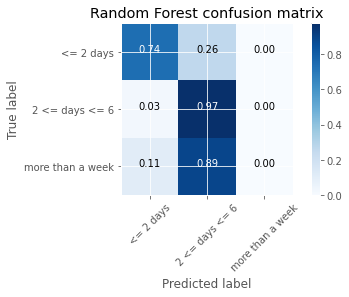

In [88]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Random Forest confusion matrix')
plt.show()

In [89]:
## over~ 
## ☆\(￣▽￣)/☆